In [65]:
import requests
import cv2
import os
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

In [66]:


# Getting Image and store it
url = 'http://10.12.105.245:8080/shot.jpg'
def get_image(url):
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)


In [67]:
# def get_image(url, save_path):
#     for i in range (100):
#         img_resp = requests.get(url)
#         img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
#         img = cv2.imdecode(img_arr, -1)
        
#         # Check if the save path exists, create it if not
#         if not os.path.exists(save_path):
#             os.makedirs(save_path)
        
#         # Save the image with a unique name in the specified folder
#         img_name = os.path.join(save_path, f'image{i}.jpg')
#         cv2.imwrite(img_name, img)
    
#     return img_name

In [60]:
save_folder = 'images'
saved_image_path = get_image(url, save_folder)

In [78]:
howmanypics = 10
personName = "Aditya"

In [62]:
int(howmanypics*0.7)

7

In [75]:
save_path_train = "trainFaces"
save_path_test = "testFaces"

In [79]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_cropped(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.2, 5)
    if len(faces) != 1:
        return None
    x, y, w, h = faces[0]
    cropped_face = img[y: y+h, x:x+w]
    return cropped_face

def process_images(url_template, save_path_train, save_path_test, personName):
    for i in range(1, howmanypics+1):  # Process 100 images
        url = url_template.format(i)
        img_resp = requests.get(url)
        img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
        img = cv2.imdecode(img_arr, -1)

        # Check if a face is detected in the first image
        if i == 1:
            face = face_cropped(img)
            if face is None:
                print("No face detected in the first image. Exiting.")
                return
        
        # Process and save the face as a 64x64 image
        face = face_cropped(img)
        face_resized = cv2.resize(face, (128, 128))
        face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
        if(i<int(howmanypics*0.7)):
            file_path = os.path.join(save_path_train, f'{personName}_{i}.jpg')
            cv2.imwrite(file_path, face_gray)
        else:
            file_path = os.path.join(save_path_test, f'{personName}_{i}.jpg')
            cv2.imwrite(file_path, face_gray)

    print("Faces cropped and saved successfully.")

# Example usage # URL template for 100 images
save_path = 'images'  # Specify where to save the cropped faces
process_images(url, save_path_train, save_path_test, personName)

Faces cropped and saved successfully.


# train and test folders

In [80]:
# Function to load and preprocess images from a folder
def load_images_from_folder(folder, image_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(filename.split('_')[0])  # Assuming filename format: "PersonName_index.jpg"
    return np.array(images), np.array(labels)

# Set your dataset directories and image size
train_dir = 'trainFaces'
test_dir = 'testFaces'
image_size = (128, 128)

# Load training and testing images and labels
X_train, y_train = load_images_from_folder(train_dir, image_size)
X_test, y_test = load_images_from_folder(test_dir, image_size)

# Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [85]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_mapping), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 9.8565 - accuracy: 0.5000 - val_loss: 233.5859 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 258ms/step - loss: 228.9324 - accuracy: 0.5000 - val_loss: 28.1333 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 240ms/step - loss: 27.9486 - accuracy: 0.5000 - val_loss: 23.6387 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 238ms/step - loss: 23.4187 - accuracy: 0.5000 - val_loss: 9.3696 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 241ms/step - loss: 9.3699 - accuracy: 0.5000 - val_loss: 5.8000 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 254ms/step - loss: 6.0028 - accuracy: 0.5000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 241ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/10
1/1 

In [87]:
test_image = cv2.imread('2.jpg')
test_image = cv2.resize(test_image, image_size)
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)
predicted_label = list(label_mapping.keys())[np.argmax(prediction)]
print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 132ms/step
Predicted Label: Aditya


# 70:30 on images

In [49]:
def load_images(directory, image_size):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(filename.split('_')[0])  # Assuming filename format: "PersonName_index.jpg"
    return np.array(images), np.array(labels)

# Set your dataset directory and image size
dataset_dir = 'images'
image_size = (128, 128)

# Load images and labels
images, labels = load_images(dataset_dir, image_size)

# Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_mapping[label] for label in labels])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [50]:

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_mapping), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 22.3125 - accuracy: 0.2857 - val_loss: 664.3250 - val_accuracy: 0.2222
Epoch 2/10
1/1 [==============================] - 0s 184ms/step - loss: 453.6009 - accuracy: 0.3810 - val_loss: 632.9321 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 186ms/step - loss: 521.4825 - accuracy: 0.3333 - val_loss: 294.6511 - val_accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 186ms/step - loss: 200.0436 - accuracy: 0.3333 - val_loss: 103.6331 - val_accuracy: 0.5556
Epoch 5/10
1/1 [==============================] - 0s 176ms/step - loss: 67.0051 - accuracy: 0.7143 - val_loss: 40.8278 - val_accuracy: 0.5556
Epoch 6/10
1/1 [==============================] - 0s 180ms/step - loss: 25.8657 - accuracy: 0.7143 - val_loss: 1.3245e-08 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 179ms/step - loss: 5.6766e-09 - accuracy: 1.0000 - val_loss: 1.2197 - val_accuracy: 0.66

In [54]:
# Example usage for prediction
test_image = cv2.imread('2.jpg')
test_image = cv2.resize(test_image, image_size)
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image)
predicted_label = list(label_mapping.keys())[np.argmax(prediction)]
print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 56ms/step
Predicted Label: Raj


In [52]:
testno = 2

# capture test images'

In [53]:

def capture_test(url_template, save_path):
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)

    
    face = face_cropped(img)
    if face is None:
        print("No face detected in the first image. Exiting.")
        return
    
    # Process and save the face as a 64x64 image
    face = face_cropped(img)
    face_resized = cv2.resize(face, (128, 128))
    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
    file_path = os.path.join(save_path, f'test{testno}.jpg')
    cv2.imwrite(file_path, face_gray)

    print("Faces cropped and saved successfully.")

# Example usage # URL template for 100 images
save_path = 'images'  # Specify where to save the cropped faces
capture_test(url, save_path)

Faces cropped and saved successfully.


In [95]:

def capture_test(url):
    face_images = []
    predicted_labels = []
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)

    
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (128, 128))
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)
        face = face / 255.0  # Normalize the image
        
        prediction = model.predict(face)
        predicted_label = list(label_mapping.keys())[np.argmax(prediction)]
        
        face_images.append(img[y:y+h, x:x+w])  # Add the face image to the list
        predicted_labels.append(predicted_label)  # Add the predicted label to the list
    
    return predicted_labels
capture_test(url)

[]

In [94]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('path/to/your/model.h5')  # Replace with the path to your trained model

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces_and_predict_labels(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    
    face_images = []
    predicted_labels = []
    
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (128, 128))
        face = np.expand_dims(face, axis=0)
        face = np.expand_dims(face, axis=-1)
        face = face / 255.0  # Normalize the image
        
        prediction = model.predict(face)
        predicted_label = list(label_mapping.keys())[np.argmax(prediction)]
        
        face_images.append(image[y:y+h, x:x+w])  # Add the face image to the list
        predicted_labels.append(predicted_label)  # Add the predicted label to the list
    
    return predicted_labels

# Example usage
image_path = 'test.jpg'  # Replace with the path to your test image
faces, labels = detect_faces_and_predict_labels(image_path)

print("Detected faces and predicted labels:")
for face, label in zip(faces, labels):
    cv2.imshow(label, face)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    print(f"Predicted Label: {label}")



OSError: No file or directory found at path/to/your/model.h5

# take out all faces

In [96]:
def capture_images(url): #, interval_seconds=5, num_images=10
    image_list = []

    # for _ in range(num_images):
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)
    # img = imutils.resize(img, width=1000, height=1800)

    image_list.append(img)
        # time.sleep(interval_seconds)

    return image_list
# url_to_capture = "http://10.12.60.98:8080//shot.jpg"
# captured_images = capture_images(url=url_to_capture, interval_seconds=2, num_images=10)

def face_cropped_from_list(images_list):
    # Load the face classifier
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    all_faces_list = []

    for img in images_list:
        faces_list = []
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect faces in the image
        faces = face_classifier.detectMultiScale(gray, 1.2, 5)

        # Iterate through detected faces
        for (x, y, w, h) in faces:
            # Crop the face from the original image
            cropped_face = img[y: y+h, x:x+w]

            # Resize the face to a common size (e.g., 200x200)
            cropped_face = cv2.resize(cropped_face, (128, 128))

            # Convert the face to grayscale
            cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2GRAY)

            # Append the face to the faces_list
            faces_list.append(cropped_face)

        # Append the faces_list to the all_faces_list
        all_faces_list.append(faces_list)

    return all_faces_list, len(all_faces_list)

x, y = face_cropped_from_list(capture_images(url))
y

1

In [98]:
import matplotlib.pyplot as plt

In [101]:
x

[[array([[224, 224, 224, ..., 255, 255, 255],
         [224, 224, 224, ..., 255, 255, 255],
         [224, 224, 224, ..., 255, 255, 255],
         ...,
         [140, 140, 140, ..., 101, 119, 131],
         [142, 142, 140, ...,  77,  85, 128],
         [142, 142, 140, ..., 132,  70,  79]], dtype=uint8)]]

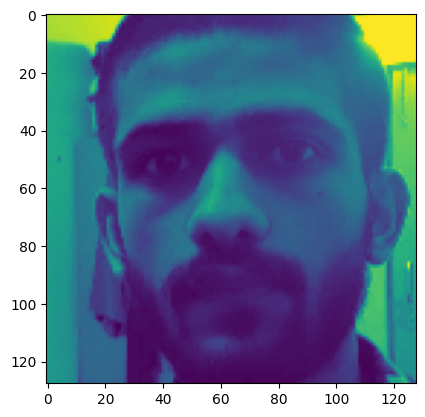

In [103]:
plt.imshow(x[0][0])

In [ ]:
hello